<a href="https://colab.research.google.com/github/tianxiang84/PINN-elastodynamics/blob/wave_1d_rod/ElasticWaveRod/PINN_Rod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
# Platform-related functions
import platform
# System specific functions
import sys
# Dealing with I/O streams
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Time-related functions
import time
# File operation
import shutil
# Serializing and de-serializing a Python object structure
import pickle

# Setup GPU for training
%tensorflow_version 1.x
import tensorflow as tf
tf.set_random_seed(1111)
# Math functions defined in C standard
import math
# Multi-dimensional array calculation
import numpy as np
np.random.seed(1111)
# Data analysis and manipulation
import pandas as pd
# Dealing with MATLAB files
import scipy.io
# Desig n of experiments for Python
!pip install --upgrade pyDOE
from pyDOE import lhs

# For plotting
import matplotlib
if platform.system()=='Linux':
    matplotlib.use('Agg')
if platform.system()=='Windows':
    from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

TensorFlow 1.x selected.
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=2a4790041244b56e91eea842e6792a8262d8ddfde5daa4122b3744767e919027
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


Check GPU availability (On Google Colab, please use Runtime --> Change runtime type is you see an empty list as output.)

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [13]:
# Note: TensorFlow 1.10 version is used
class PINN:
    # Initialize the class
    def __init__(self, Collo, HOLE, IC, LF, RT, UP, LW, DIST, uv_layers, dist_layers, part_layers, lb, ub,
                 partDir='', distDir='', uvDir=''):

        # Count for callback function
        self.count = 0

        # Bounds
        self.lb = lb
        self.ub = ub

        # Mat. properties
        self.E = 20.0
        self.mu = 0.25
        self.rho = 1.0
        self.hole_r = 0.1

        # Collocation point
        self.x_c = Collo[:, 0:1]
        self.y_c = Collo[:, 1:2]
        self.t_c = Collo[:, 2:3]

        # Source wave
        self.x_HOLE = HOLE[:, 0:1]
        self.y_HOLE = HOLE[:, 1:2]
        self.t_HOLE = HOLE[:, 2:3]

        # Initial condition point, t=0
        self.x_IC = IC[:, 0:1]
        self.y_IC = IC[:, 1:2]
        self.t_IC = IC[:, 2:3]

        # Symmetry bound, where u=s12=0
        self.x_LF = LF[:, 0:1]
        self.y_LF = LF[:, 1:2]
        self.t_LF = LF[:, 2:3]

        # Loading bound, where s12=0, s11=func(t)
        self.x_RT = RT[:, 0:1]
        self.y_RT = RT[:, 1:2]
        self.t_RT = RT[:, 2:3]
        self.s11_RT = RT[:, 3:4]

        # Free bound, where s12=s22=0
        self.x_UP = UP[:, 0:1]
        self.y_UP = UP[:, 1:2]
        self.t_UP = UP[:, 2:3]

        # Symmetry bound, where s12=0, v=0
        self.x_LW = LW[:, 0:1]
        self.y_LW = LW[:, 1:2]
        self.t_LW = LW[:, 2:3]

        # Distance function
        self.x_dist = DIST[:, 0:1]
        self.y_dist = DIST[:, 1:2]
        self.t_dist = DIST[:, 2:3]
        self.u_dist = DIST[:, 3:4]
        self.v_dist = DIST[:, 4:5]
        self.s11_dist = DIST[:, 5:6]
        self.s22_dist = DIST[:, 6:7]
        self.s12_dist = DIST[:, 7:8]

        # Define layers config
        self.uv_layers = uv_layers
        self.dist_layers = dist_layers
        self.part_layers = part_layers

        # Load trained network if provided, else initialize them randomly.
        if distDir == '':
            self.dist_weights, self.dist_biases = self.initialize_NN(self.dist_layers)
        else:
            print("Loading dist NN ...")
            self.dist_weights, self.dist_biases = self.load_NN(distDir, self.dist_layers)

        if partDir == '':
            self.part_weights, self.part_biases = self.initialize_NN(self.part_layers)
        else:
            print("Loading part NN ...")
            self.part_weights, self.part_biases = self.load_NN(partDir, self.part_layers)

        if uvDir=='':
            self.uv_weights, self.uv_biases = self.initialize_NN(self.uv_layers)
        else:
            print("Loading uv NN ...")
            self.uv_weights, self.uv_biases = self.load_NN(uvDir, self.uv_layers)

        # tf placeholders
        self.learning_rate = tf.placeholder(tf.float64, shape=[])
        self.x_tf = tf.placeholder(tf.float64, shape=[None, self.x_c.shape[1]])  # Point for postprocessing
        self.y_tf = tf.placeholder(tf.float64, shape=[None, self.y_c.shape[1]])
        self.t_tf = tf.placeholder(tf.float64, shape=[None, self.t_c.shape[1]])

        self.x_c_tf = tf.placeholder(tf.float64, shape=[None, self.x_c.shape[1]])
        self.y_c_tf = tf.placeholder(tf.float64, shape=[None, self.y_c.shape[1]])
        self.t_c_tf = tf.placeholder(tf.float64, shape=[None, self.t_c.shape[1]])

        self.x_HOLE_tf = tf.placeholder(tf.float64, shape=[None, self.x_HOLE.shape[1]])
        self.y_HOLE_tf = tf.placeholder(tf.float64, shape=[None, self.y_HOLE.shape[1]])
        self.t_HOLE_tf = tf.placeholder(tf.float64, shape=[None, self.t_HOLE.shape[1]])

        self.x_IC_tf = tf.placeholder(tf.float64, shape=[None, self.x_IC.shape[1]])
        self.y_IC_tf = tf.placeholder(tf.float64, shape=[None, self.y_IC.shape[1]])
        self.t_IC_tf = tf.placeholder(tf.float64, shape=[None, self.t_IC.shape[1]])

        self.x_LF_tf = tf.placeholder(tf.float64, shape=[None, self.x_LF.shape[1]])
        self.y_LF_tf = tf.placeholder(tf.float64, shape=[None, self.y_LF.shape[1]])
        self.t_LF_tf = tf.placeholder(tf.float64, shape=[None, self.t_LF.shape[1]])

        self.x_RT_tf = tf.placeholder(tf.float64, shape=[None, self.x_RT.shape[1]])
        self.y_RT_tf = tf.placeholder(tf.float64, shape=[None, self.y_RT.shape[1]])
        self.t_RT_tf = tf.placeholder(tf.float64, shape=[None, self.t_RT.shape[1]])
        self.s11_RT_tf = tf.placeholder(tf.float64, shape=[None, self.s11_RT.shape[1]])

        self.x_UP_tf = tf.placeholder(tf.float64, shape=[None, self.x_UP.shape[1]])
        self.y_UP_tf = tf.placeholder(tf.float64, shape=[None, self.y_UP.shape[1]])
        self.t_UP_tf = tf.placeholder(tf.float64, shape=[None, self.t_UP.shape[1]])

        self.x_LW_tf = tf.placeholder(tf.float64, shape=[None, self.x_LW.shape[1]])
        self.y_LW_tf = tf.placeholder(tf.float64, shape=[None, self.y_LW.shape[1]])
        self.t_LW_tf = tf.placeholder(tf.float64, shape=[None, self.t_LW.shape[1]])

        self.x_dist_tf = tf.placeholder(tf.float64, shape=[None, self.x_dist.shape[1]])
        self.y_dist_tf = tf.placeholder(tf.float64, shape=[None, self.y_dist.shape[1]])
        self.t_dist_tf = tf.placeholder(tf.float64, shape=[None, self.t_dist.shape[1]])
        self.u_dist_tf = tf.placeholder(tf.float64, shape=[None, self.u_dist.shape[1]])
        self.v_dist_tf = tf.placeholder(tf.float64, shape=[None, self.v_dist.shape[1]])
        self.s11_dist_tf = tf.placeholder(tf.float64, shape=[None, self.s11_dist.shape[1]])
        self.s22_dist_tf = tf.placeholder(tf.float64, shape=[None, self.s22_dist.shape[1]])
        self.s12_dist_tf = tf.placeholder(tf.float64, shape=[None, self.s12_dist.shape[1]])

        # tf graphs
        self.u_pred, self.v_pred, self.s11_pred, self.s22_pred, self.s12_pred = self.net_uv(self.x_tf, self.y_tf, self.t_tf)
        self.e11_pred, self.e22_pred, self.e12_pred = self.net_e(self.x_tf, self.y_tf, self.t_tf)
        # Distance function
        self.D_u_pred, self.D_v_pred, self.D_s11_pred, self.D_s22_pred, self.D_s12_pred \
              = self.net_dist(self.x_dist_tf, self.y_dist_tf, self.t_dist_tf)

        # Time derivatives of distance func (to enforce zero-velocity IC later)
        self.dt_D_u_pred, self.dt_D_v_pred, self.dt_D_s11_pred, self.dt_D_s22_pred, self.dt_D_s12_pred \
              = self.net_dist_dt(self.x_IC_tf, self.y_IC_tf, self.t_IC_tf)
        # Particular solution (at boundary, initial state)
        self.P_u_pred, self.P_v_pred, self.P_s11_pred, self.P_s22_pred, self.P_s12_pred, _, _ \
              = self.net_part(self.x_tf, self.y_tf, self.t_tf)

        self.P_u_IC_pred, self.P_v_IC_pred, self.P_s11_IC_pred, self.P_s22_IC_pred, self.P_s12_IC_pred, \
              self.dt_P_u_IC_pred, self.dt_P_v_IC_pred = self.net_part(self.x_IC_tf, self.y_IC_tf, self.t_IC_tf)
        self.P_u_LF_pred, _, _, _, self.P_s12_LF_pred, _, _ = self.net_part(self.x_LF_tf, self.y_LF_tf, self.t_LF_tf)
        _, _, self.P_s11_RT_pred, _, self.P_s12_RT_pred, _, _ = self.net_part(self.x_RT_tf, self.y_RT_tf, self.t_RT_tf)
        _, self.P_v_LW_pred, _, _, self.P_s12_LW_pred, _, _ = self.net_part(self.x_LW_tf, self.y_LW_tf, self.t_LW_tf)
        _, _, _, self.P_s22_UP_pred, self.P_s12_UP_pred, _, _ = self.net_part(self.x_UP_tf, self.y_UP_tf, self.t_UP_tf)

        # Surface traction on circular hole
        self.tx_pred, self.ty_pred = self.net_t(self.x_HOLE_tf, self.y_HOLE_tf, self.t_HOLE_tf)
        # Governing eqn residual on collocation points
        self.f_pred_u, self.f_pred_v, self.f_pred_s11, self.f_pred_s22, self.f_pred_s12 = self.net_f_sig(self.x_c_tf,
                                                                                                         self.y_c_tf,
                                                                                                         self.t_c_tf)

        # Construct loss to optimize
        self.loss_f_uv = tf.reduce_mean(tf.square(self.f_pred_u)) \
                         + tf.reduce_mean(tf.square(self.f_pred_v))
        self.loss_f_s = tf.reduce_mean(tf.square(self.f_pred_s11)) \
                        + tf.reduce_mean(tf.square(self.f_pred_s22)) \
                        + tf.reduce_mean(tf.square(self.f_pred_s12))
        self.loss_HOLE = tf.reduce_mean(tf.square(self.tx_pred)) \
                         + tf.reduce_mean(tf.square(self.ty_pred))
        self.loss_DIST = tf.reduce_mean(tf.square(self.D_u_pred - self.u_dist_tf)) \
                         + tf.reduce_mean(tf.square(self.D_v_pred - self.v_dist_tf)) \
                         + tf.reduce_mean(tf.square(self.D_s11_pred - self.s11_dist_tf)) \
                         + tf.reduce_mean(tf.square(self.D_s22_pred - self.s22_dist_tf)) \
                         + tf.reduce_mean(tf.square(self.D_s12_pred - self.s12_dist_tf)) \
                         + tf.reduce_mean(tf.square(self.dt_D_u_pred)) \
                         + tf.reduce_mean(tf.square(self.dt_D_v_pred))
        self.loss_PART = tf.reduce_mean(tf.square(self.P_u_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.P_v_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s11_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s22_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s12_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.dt_P_u_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.dt_P_v_IC_pred)) \
                         + tf.reduce_mean(tf.square(self.P_u_LF_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s12_LF_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s11_RT_pred - self.s11_RT_tf)) \
                         + tf.reduce_mean(tf.square(self.P_s12_RT_pred)) \
                         + tf.reduce_mean(tf.square(self.P_v_LW_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s12_LW_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s22_UP_pred)) \
                         + tf.reduce_mean(tf.square(self.P_s12_UP_pred)) \

        self.loss = 10 * (self.loss_f_uv + self.loss_f_s + self.loss_HOLE)

        # Optimizer to pretrain distance func network
        self.optimizer_dist = tf.contrib.opt.ScipyOptimizerInterface(1000 * self.loss_DIST,
                                                                     var_list=self.dist_weights + self.dist_biases,
                                                                     method='L-BFGS-B',
                                                                     options={'maxiter': 20000,
                                                                              'maxfun': 20000,
                                                                              'maxcor': 50,
                                                                              'maxls': 50,
                                                                              'ftol': 0.00001 * np.finfo(float).eps})

        # Optimizer to pretrain particular solution network
        self.optimizer_part = tf.contrib.opt.ScipyOptimizerInterface(1000 * self.loss_PART,
                                                                     var_list=self.part_weights + self.part_biases,
                                                                     method='L-BFGS-B',
                                                                     options={'maxiter': 20000,
                                                                              'maxfun': 20000,
                                                                              'maxcor': 50,
                                                                              'maxls': 50,
                                                                              'ftol': 0.00001 * np.finfo(float).eps})

        # Optimizer for final solution (while the dist, particular network freezed)
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                var_list=self.uv_weights + self.uv_biases,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 70000,
                                                                         'maxfun': 70000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 0.00001 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list=self.uv_weights + self.uv_biases)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64),
                           dtype=tf.float64)

    def save_NN(self, fileDir, TYPE=''):
        if TYPE == 'UV':
            uv_weights = self.sess.run(self.uv_weights)
            uv_biases = self.sess.run(self.uv_biases)
        elif TYPE == 'DIST':
            uv_weights = self.sess.run(self.dist_weights)
            uv_biases = self.sess.run(self.dist_biases)
        elif TYPE == 'PART':
            uv_weights = self.sess.run(self.part_weights)
            uv_biases = self.sess.run(self.part_biases)
        else:
            pass
        with open(fileDir, 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            print("Save " + TYPE + " NN parameters successfully...")

    def load_NN(self, fileDir, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        with open(fileDir, 'rb') as f:
            uv_weights, uv_biases = pickle.load(f)
            # Stored model must has the same # of layers
            assert num_layers == (len(uv_weights) + 1)
            for num in range(0, num_layers - 1):
                W = tf.Variable(uv_weights[num], dtype=tf.float64)
                b = tf.Variable(uv_biases[num], dtype=tf.float64)
                weights.append(W)
                biases.append(b)
                print("Load NN parameters successfully...")
        return weights, biases

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        # Note: for cases where X is very large or small, use the below normalization
        # H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_dist(self, x, y, t):
        dist = self.neural_net(tf.concat([x, y, t], 1), self.dist_weights, self.dist_biases)
        D_u = dist[:, 0:1]
        D_v = dist[:, 1:2]
        D_s11 = dist[:, 2:3]
        D_s22 = dist[:, 3:4]
        D_s12 = dist[:, 4:5]
        return D_u, D_v, D_s11, D_s22, D_s12

    def net_dist_dt(self, x, y, t):
        # Time derivative of distance function
        dist = self.neural_net(tf.concat([x, y, t], 1), self.dist_weights, self.dist_biases)
        D_u = dist[:, 0:1]
        D_v = dist[:, 1:2]
        D_s11 = dist[:, 2:3]
        D_s22 = dist[:, 3:4]
        D_s12 = dist[:, 4:5]

        dt_D_u = tf.gradients(D_u, t)[0]
        dt_D_v = tf.gradients(D_v, t)[0]
        dt_D_s11 = tf.gradients(D_s11, t)[0]
        dt_D_s22 = tf.gradients(D_s22, t)[0]
        dt_D_s12 = tf.gradients(D_s12, t)[0]
        return dt_D_u, dt_D_v, dt_D_s11, dt_D_s22, dt_D_s12

    def net_part(self, x, y, t):
        P = self.neural_net(tf.concat([x, y, t], 1), self.part_weights, self.part_biases)
        P_u = P[:, 0:1]
        P_v = P[:, 1:2]
        P_s11 = P[:, 2:3]
        P_s22 = P[:, 3:4]
        P_s12 = P[:, 4:5]
        dt_P_u = tf.gradients(P_u, t)[0]
        dt_P_v = tf.gradients(P_v, t)[0]
        return P_u, P_v, P_s11, P_s22, P_s12, dt_P_u, dt_P_v

    def net_uv(self, x, y, t):
        # Output for composite network, i.e. [u, v, s11, s22, s12]
        uv_sig = self.neural_net(tf.concat([x, y, t], 1), self.uv_weights, self.uv_biases)
        dist = self.neural_net(tf.concat([x, y, t], 1), self.dist_weights, self.dist_biases)
        part = self.neural_net(tf.concat([x, y, t], 1), self.part_weights, self.part_biases)

        u = uv_sig[:, 0:1]
        v = uv_sig[:, 1:2]
        s11 = uv_sig[:, 2:3]
        s22 = uv_sig[:, 3:4]
        s12 = uv_sig[:, 4:5]

        P_u = part[:, 0:1]
        P_v = part[:, 1:2]
        P_s11 = part[:, 2:3]
        P_s22 = part[:, 3:4]
        P_s12 = part[:, 4:5]

        D_u = dist[:, 0:1]
        D_v = dist[:, 1:2]
        D_s11 = dist[:, 2:3]
        D_s22 = dist[:, 3:4]
        D_s12 = dist[:, 4:5]

        #####p(x,y)+D(x,y)*u(x,y)######
        u = P_u + D_u * u
        v = P_v + D_v * v
        s11 = P_s11 + D_s11 * s11
        s22 = P_s22 + D_s22 * s22
        s12 = P_s12 + D_s12 * s12
        return u, v, s11, s22, s12

    def net_e(self, x, y, t):
        u, v, _, _, _ = self.net_uv(x, y, t)
        # Strains
        e11 = tf.gradients(u, x)[0]
        e22 = tf.gradients(v, y)[0]
        e12 = (tf.gradients(u, y)[0] + tf.gradients(v, x)[0])
        return e11, e22, e12

    def net_vel(self, x, y, t):
        u, v, _, _, _ = self.net_uv(x, y, t)
        u_t = tf.gradients(u, t)[0]
        v_t = tf.gradients(v, t)[0]
        return u_t, v_t

    def net_f_sig(self, x, y, t):
        # Network for governing (and constitutive) equation loss
        E = self.E
        mu = self.mu
        rho = self.rho

        u, v, s11, s22, s12 = self.net_uv(x, y, t)

        # Strains
        e11, e22, e12 = self.net_e(x, y, t)

        # Plane stress from auto-differentiation
        sp11 = E / (1 - mu * mu) * e11 + E * mu / (1 - mu * mu) * e22
        sp22 = E * mu / (1 - mu * mu) * e11 + E / (1 - mu * mu) * e22
        sp12 = E / (2 * (1 + mu)) * e12

        # raw stress output - stress from auto-differentiation
        f_s11 = s11 - sp11
        f_s12 = s12 - sp12
        f_s22 = s22 - sp22

        s11_1 = tf.gradients(s11, x)[0]
        s12_2 = tf.gradients(s12, y)[0]
        u_t = tf.gradients(u, t)[0]
        u_tt = tf.gradients(u_t, t)[0]

        s22_2 = tf.gradients(s22, y)[0]
        s12_1 = tf.gradients(s12, x)[0]
        v_t = tf.gradients(v, t)[0]
        v_tt = tf.gradients(v_t, t)[0]

        # f_u:=Sxx_x+Sxy_y-rho*u_tt
        f_u = s11_1 + s12_2 - rho * u_tt
        f_v = s22_2 + s12_1 - rho * v_tt

        return f_u, f_v, f_s11, f_s22, f_s12

    def net_surf_var(self, x, y, t, nx, ny):
        # In this function, the nx, ny for one edge is same
        # Return surface traction tx, ty

        u, v, s11, s22, s12 = self.net_uv(x, y, t)

        tx = tf.multiply(s11, nx) + tf.multiply(s12, ny)
        ty = tf.multiply(s12, nx) + tf.multiply(s22, ny)

        return tx, ty

    def net_t(self, x, y, t):
        # Calculate traction tx, ty for circular surface from coordinate x, y
        r = self.hole_r
        u, v, s11, s22, s12 = self.net_uv(x, y, t)
        # Todo: add nx, ny vector for each x, y
        nx = -x / r
        ny = -y / r
        tx = tf.multiply(s11, nx, name=None) + tf.multiply(s12, ny, name=None)
        ty = tf.multiply(s12, nx, name=None) + tf.multiply(s22, ny, name=None)
        return tx, ty

    def callback(self, loss):
        self.count = self.count + 1
        print('{} th iterations, Loss: {}'.format(self.count, loss))

    def callback_dist(self, loss_dist):
        self.count = self.count + 1
        print('{} th iterations, Loss: {}'.format(self.count, loss_dist))

    def callback_part(self, loss_part):
        self.count = self.count + 1
        print('{} th iterations, Loss: {}'.format(self.count, loss_part))

    def train(self, iter, learning_rate):

        loss_f_uv = []
        loss_f_s = []
        loss_HOLE = []
        loss = []

        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c, self.t_c_tf: self.t_c,
                   self.x_IC_tf: self.x_IC, self.y_IC_tf: self.y_IC, self.t_IC_tf: self.t_IC,
                   self.x_HOLE_tf: self.x_HOLE, self.y_HOLE_tf: self.y_HOLE, self.t_HOLE_tf: self.t_HOLE,
                   self.x_LF_tf: self.x_LF, self.y_LF_tf: self.y_LF, self.t_LF_tf: self.t_LF,
                   self.x_RT_tf: self.x_RT, self.y_RT_tf: self.y_RT, self.t_RT_tf: self.t_RT,
                   self.s11_RT_tf: self.s11_RT,
                   self.x_UP_tf: self.x_UP, self.y_UP_tf: self.y_UP, self.t_UP_tf: self.t_UP,
                   self.x_LW_tf: self.x_LW, self.y_LW_tf: self.y_LW, self.t_LW_tf: self.t_LW,
                   self.x_dist_tf: self.x_dist, self.y_dist_tf: self.y_dist, self.t_dist_tf: self.t_dist,
                   self.u_dist_tf: self.u_dist,
                   self.v_dist_tf: self.v_dist, self.s11_dist_tf: self.s11_dist, self.s22_dist_tf: self.s22_dist,
                   self.s12_dist_tf: self.s12_dist,
                   self.learning_rate: learning_rate}

        for it in range(iter):
            self.sess.run(self.train_op_Adam, tf_dict)
            # Print
            if it % 10 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.6e' % (it, loss_value))
            loss_f_uv.append(self.sess.run(self.loss_f_uv, tf_dict))
            loss_f_s.append(self.sess.run(self.loss_f_s, tf_dict))
            loss_HOLE.append(self.sess.run(self.loss_HOLE, tf_dict))
            loss.append(self.sess.run(self.loss, tf_dict))
        return loss_f_uv, loss_f_s, loss_HOLE, loss

    def train_bfgs(self):
        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c, self.t_c_tf: self.t_c,
                   self.x_IC_tf: self.x_IC, self.y_IC_tf: self.y_IC, self.t_IC_tf: self.t_IC,
                   self.x_HOLE_tf: self.x_HOLE, self.y_HOLE_tf: self.y_HOLE, self.t_HOLE_tf: self.t_HOLE,
                   self.x_LF_tf: self.x_LF, self.y_LF_tf: self.y_LF, self.t_LF_tf: self.t_LF,
                   self.x_RT_tf: self.x_RT, self.y_RT_tf: self.y_RT, self.t_RT_tf: self.t_RT,
                   self.s11_RT_tf: self.s11_RT,
                   self.x_UP_tf: self.x_UP, self.y_UP_tf: self.y_UP, self.t_UP_tf: self.t_UP,
                   self.x_LW_tf: self.x_LW, self.y_LW_tf: self.y_LW, self.t_LW_tf: self.t_LW,
                   self.x_dist_tf: self.x_dist, self.y_dist_tf: self.y_dist, self.t_dist_tf: self.t_dist,
                   self.u_dist_tf: self.u_dist,
                   self.v_dist_tf: self.v_dist, self.s11_dist_tf: self.s11_dist, self.s22_dist_tf: self.s22_dist,
                   self.s12_dist_tf: self.s12_dist}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

    def train_bfgs_dist(self):

        tf_dict = {self.x_IC_tf: self.x_IC, self.y_IC_tf: self.y_IC, self.t_IC_tf: self.t_IC,
                   self.x_HOLE_tf: self.x_HOLE, self.y_HOLE_tf: self.y_HOLE, self.t_HOLE_tf: self.t_HOLE,
                   self.x_LF_tf: self.x_LF, self.y_LF_tf: self.y_LF, self.t_LF_tf: self.t_LF,
                   self.x_RT_tf: self.x_RT, self.y_RT_tf: self.y_RT, self.t_RT_tf: self.t_RT,
                   self.s11_RT_tf: self.s11_RT,
                   self.x_UP_tf: self.x_UP, self.y_UP_tf: self.y_UP, self.t_UP_tf: self.t_UP,
                   self.x_LW_tf: self.x_LW, self.y_LW_tf: self.y_LW, self.t_LW_tf: self.t_LW,
                   self.x_dist_tf: self.x_dist, self.y_dist_tf: self.y_dist, self.t_dist_tf: self.t_dist,
                   self.u_dist_tf: self.u_dist,
                   self.v_dist_tf: self.v_dist, self.s11_dist_tf: self.s11_dist, self.s22_dist_tf: self.s22_dist,
                   self.s12_dist_tf: self.s12_dist}

        self.optimizer_dist.minimize(self.sess,
                                     feed_dict=tf_dict,
                                     fetches=[self.loss_DIST],
                                     loss_callback=self.callback_dist)

    def train_bfgs_part(self):

        tf_dict = {self.x_IC_tf: self.x_IC, self.y_IC_tf: self.y_IC, self.t_IC_tf: self.t_IC,
                   self.x_HOLE_tf: self.x_HOLE, self.y_HOLE_tf: self.y_HOLE, self.t_HOLE_tf: self.t_HOLE,
                   self.x_LF_tf: self.x_LF, self.y_LF_tf: self.y_LF, self.t_LF_tf: self.t_LF,
                   self.x_RT_tf: self.x_RT, self.y_RT_tf: self.y_RT, self.t_RT_tf: self.t_RT,
                   self.s11_RT_tf: self.s11_RT,
                   self.x_UP_tf: self.x_UP, self.y_UP_tf: self.y_UP, self.t_UP_tf: self.t_UP,
                   self.x_LW_tf: self.x_LW, self.y_LW_tf: self.y_LW, self.t_LW_tf: self.t_LW}

        self.optimizer_part.minimize(self.sess,
                                     feed_dict=tf_dict,
                                     fetches=[self.loss_PART],
                                     loss_callback=self.callback_part)

    def predict(self, x_star, y_star, t_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        v_star = self.sess.run(self.v_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        s11_star = self.sess.run(self.s11_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        s22_star = self.sess.run(self.s22_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        s12_star = self.sess.run(self.s12_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        e11_star = self.sess.run(self.e11_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        e22_star = self.sess.run(self.e22_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        e12_star = self.sess.run(self.e12_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        return u_star, v_star, s11_star, s22_star, s12_star, e11_star, e22_star, e12_star

    def predict_D(self, x_star, y_star, t_star):
        D_u = self.sess.run(self.D_u_pred, {self.x_dist_tf: x_star, self.y_dist_tf: y_star, self.t_dist_tf: t_star})
        D_v = self.sess.run(self.D_v_pred, {self.x_dist_tf: x_star, self.y_dist_tf: y_star, self.t_dist_tf: t_star})
        D_s11 = self.sess.run(self.D_s11_pred, {self.x_dist_tf: x_star, self.y_dist_tf: y_star, self.t_dist_tf: t_star})
        D_s22 = self.sess.run(self.D_s22_pred, {self.x_dist_tf: x_star, self.y_dist_tf: y_star, self.t_dist_tf: t_star})
        D_s12 = self.sess.run(self.D_s12_pred, {self.x_dist_tf: x_star, self.y_dist_tf: y_star, self.t_dist_tf: t_star})
        return D_u, D_v, D_s11, D_s22, D_s12

    def predict_P(self, x_star, y_star, t_star):
        P_u = self.sess.run(self.P_u_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        P_v = self.sess.run(self.P_v_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        P_s11 = self.sess.run(self.P_s11_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        P_s22 = self.sess.run(self.P_s22_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        P_s12 = self.sess.run(self.P_s12_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        return P_u, P_v, P_s11, P_s22, P_s12

    def getloss(self):
        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c, self.t_c_tf: self.t_c,
                   self.x_IC_tf: self.x_IC, self.y_IC_tf: self.y_IC, self.t_IC_tf: self.t_IC,
                   self.x_HOLE_tf: self.x_HOLE, self.y_HOLE_tf: self.y_HOLE, self.t_HOLE_tf: self.t_HOLE,
                   self.x_LF_tf: self.x_LF, self.y_LF_tf: self.y_LF, self.t_LF_tf: self.t_LF,
                   self.x_RT_tf: self.x_RT, self.y_RT_tf: self.y_RT, self.t_RT_tf: self.t_RT,
                   self.s11_RT_tf: self.s11_RT,
                   self.x_UP_tf: self.x_UP, self.y_UP_tf: self.y_UP, self.t_UP_tf: self.t_UP,
                   self.x_LW_tf: self.x_LW, self.y_LW_tf: self.y_LW, self.t_LW_tf: self.t_LW,
                   self.x_dist_tf: self.x_dist, self.y_dist_tf: self.y_dist, self.t_dist_tf: self.t_dist,
                   self.u_dist_tf: self.u_dist,
                   self.v_dist_tf: self.v_dist, self.s11_dist_tf: self.s11_dist, self.s22_dist_tf: self.s22_dist,
                   self.s12_dist_tf: self.s12_dist}
        loss_f_uv = self.sess.run(self.loss_f_uv, tf_dict)
        loss_f_s = self.sess.run(self.loss_f_s, tf_dict)
        loss_HOLE = self.sess.run(self.loss_HOLE, tf_dict)
        loss = self.sess.run(self.loss, tf_dict)
        loss_PART = self.sess.run(self.loss_PART, tf_dict)
        loss_DIST = self.sess.run(self.loss_DIST, tf_dict)
        print('loss_f_uv', loss_f_uv)
        print('loss_f_s', loss_f_s)
        print('loss_HOLE', loss_HOLE)
        print('loss', loss)
        print('loss_PART', loss_PART)
        print('loss_DIST', loss_DIST)

Functions to generate rows of samples: x, y, t, u, v, s11, s22, s12

In [4]:
def GenDistPt(xmin, xmax, ymin, ymax, tmin, tmax, xc, yc, r, num_surf_pt, num, num_t):
    # Function to generate discret points in the x-y-t domain
    # First generate a uniform x-y grid
    # Then delete the points in the hole
    # Then add the points lining the hole
    # Finally add time dimension points

    # num: number per edge
    # num_t: number time step

    x = np.linspace(xmin, xmax, num=num)
    y = np.linspace(ymin, ymax, num=num)
    x, y = np.meshgrid(x, y)

    # Delete point in hole
    dst = ((x - xc) ** 2 + (y - yc) ** 2) ** 0.5
    x = x[dst >= r]
    y = y[dst >= r]
    x = x.flatten()[:, None]
    y = y.flatten()[:, None]

    # Refinement point near hole surface
    theta = np.linspace(0.0, np.pi / 2.0, num_surf_pt)
    x_surf = np.multiply(r, np.cos(theta)) + xc
    y_surf = np.multiply(r, np.sin(theta)) + yc
    x_surf = x_surf.flatten()[:, None]
    y_surf = y_surf.flatten()[:, None]
    x = np.concatenate((x, x_surf), 0)
    y = np.concatenate((y, y_surf), 0)

    # Cartisian product with time points
    t = np.linspace(tmin, tmax, num=num_t)
    xxx, ttt = np.meshgrid(x, t)
    yyy,   _ = np.meshgrid(y, t)
    xxx = xxx.flatten()[:, None]
    yyy = yyy.flatten()[:, None]
    ttt = ttt.flatten()[:, None]
    return xxx, yyy, ttt

def GenDist(XYT_dist):
    # Pass in XYT, outptu XYT, u, v, s11, s22, s12
    
    dist_u = np.zeros_like(XYT_dist[:, 0:1]) # Return an array of zeros with the same shape and type as a given array.
    dist_v = np.zeros_like(XYT_dist[:, 0:1])
    dist_s11 = np.zeros_like(XYT_dist[:, 0:1])
    dist_s22 = np.zeros_like(XYT_dist[:, 0:1])
    dist_s12 = np.zeros_like(XYT_dist[:, 0:1])

    for i in range(len(XYT_dist)):
        dist_u[i, 0] = min(XYT_dist[i][2], XYT_dist[i][0])  # min(t, x-(-0.5))
        dist_v[i, 0] = min(XYT_dist[i][2], XYT_dist[i][1])  # min(t, sqrt((x+0.5)^2+(y+0.5)^2))
        dist_s11[i, 0] = min(XYT_dist[i][2], 0.5 - XYT_dist[i][0])
        dist_s22[i, 0] = min(XYT_dist[i][2], 0.5 - XYT_dist[i][1])  # min(t, 0.5-y, 0.5+y)
        dist_s12[i, 0] = min(XYT_dist[i][2], XYT_dist[i][1], 0.5 - XYT_dist[i][1], XYT_dist[i][0], 0.5 - XYT_dist[i][0])
    
    DIST = np.concatenate((XYT_dist, dist_u, dist_v, dist_s11, dist_s22, dist_s12), 1)

    return DIST

def DelHolePT(XYT_c, xc=0, yc=0, r=0.1):
    # Input rows of points [x,y,t]
    # Delete points within hole
    # Return only the points outside the hole
    
    dst = np.array([((xyt[0] - xc) ** 2 + (xyt[1] - yc) ** 2) ** 0.5 for xyt in XYT_c])

    return XYT_c[dst > r, :]


def GenHoleSurfPT(xc, yc, r, N_PT):
    # Generate
    theta = np.linspace(0.0, np.pi / 2.0, N_PT)
    xx = np.multiply(r, np.cos(theta)) + xc
    yy = np.multiply(r, np.sin(theta)) + yc
    xx = xx.flatten()[:, None]
    yy = yy.flatten()[:, None]
    return xx, yy

Parameters

In [5]:
PI = math.pi
MAX_T = 10.0

# Domain bounds for x, y and t
lb = np.array([0.0, 0.0,   0.0]) # lower bounds for (x,y,t)
ub = np.array([0.5, 0.5, MAX_T]) # upper bounds for (x,y,t)

# Network configuration
uv_layers   = [3] + 8 * [70] + [5] #list [3, 70, ...., 70, 5]
dist_layers = [3] + 4 * [20] + [5]
part_layers = [3] + 4 * [20] + [5]

# ????????????????????????????????? #
# Number of frames for postprocessing
N_t = int(MAX_T * 8 + 1) #integer: 81

In [6]:
# Generate distance function for spatio-temporal space
x_dist, y_dist, t_dist = GenDistPt(xmin=0, xmax=0.5, ymin=0, ymax=0.5, tmin=0, tmax=10, xc=0, yc=0, r=0.1,
                                       num_surf_pt=40, num=21, num_t=21)
# x_dist: (9786,1)
# y_dist: (9786,1)
# t_dist: (9786,1)

XYT_dist = np.concatenate((x_dist, y_dist, t_dist), 1)
# XYT_dist: (9786,3) (x1,y1,t1; x2,y2,t2)

# ????????????????????????????????? #
DIST = GenDist(XYT_dist)
# XYT, u, v, s11, s22, s12
# DIST: (9786, 8)

# Initial condition points for u, v
IC = lb + np.array([0.5, 0.5, 0.0]) * lhs(3, 5000) #Latin hypercube sampling
IC = DelHolePT(IC, xc=0, yc=0, r=0.1) # Delete the points in the hole

# IC: not deterministic, e.g, (4833,3), filtered from (5000, 3)
# [x1,y1,0]
# [x2,y2,0]

# Collocation point for equation residual: x in (0, 0.5) , y in (0, 0.5)
XYT_c = lb + (ub - lb) * lhs(3, 70000)
XYT_c_ref = lb + np.array([0.15, 0.15, 10.0]) * lhs(3, 40000)  # Refinement for stress concentration
XYT_c = np.concatenate((XYT_c, XYT_c_ref), 0)
XYT_c = DelHolePT(XYT_c, xc=0, yc=0, r=0.1)

# XYT_c.shape = (93831,3)

# Points along the hole (center at 0, 0, radius is 0.1)
xx, yy = GenHoleSurfPT(xc=0, yc=0, r=0.1, N_PT=83)
tt = np.linspace(0, 10, 121)
tt = tt[1:] # Delete the first point
x_ho, t_ho = np.meshgrid(xx, tt)
y_ho, _ = np.meshgrid(yy, tt)
x_ho = x_ho.flatten()[:, None]
y_ho = y_ho.flatten()[:, None]
t_ho = t_ho.flatten()[:, None]
HOLE = np.concatenate((x_ho, y_ho, t_ho), 1)

# Boundary points
LW = np.array([0.1, 0.0, 0.0]) + np.array([0.4, 0.0, 10]) * lhs(3, 8000)
UP = np.array([0.0, 0.5, 0.0]) + np.array([0.5, 0.0, 10]) * lhs(3, 8000)
LF = np.array([0.0, 0.1, 0.0]) + np.array([0.0, 0.4, 10]) * lhs(3, 8000)
RT = np.array([0.5, 0.0, 0.0]) + np.array([0.0, 0.5, 10]) * lhs(3, 13000)

t_RT = RT[:, 2:3]
period = 5  # two period in 10s
s11_RT = 0.5 * np.sin((2 * PI / period) * t_RT + 3 * PI / 2) + 0.5
RT = np.concatenate((RT, s11_RT), 1)
# RT has the shape of (13000,4) now: x, y, t and (s11_t?)

# Add some boundary points into the collocation point set
XYT_c = np.concatenate((XYT_c, HOLE[::4, :], LF[::5, :], RT[::5, 0:3], UP[::5, :], LW[::5, :]), 0)

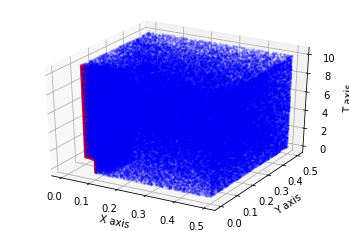

In [7]:
# Visualize ALL the training points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XYT_c[:,0:1], XYT_c[:,1:2], XYT_c[:,2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(IC[:, 0:1], IC[:, 1:2], IC[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(LW[:, 0:1], LW[:, 1:2], LW[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(UP[:, 0:1], UP[:, 1:2], UP[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(LF[:, 0:1], LF[:, 1:2], LF[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(RT[:, 0:1], RT[:, 1:2], RT[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(HOLE[:, 0:1], HOLE[:, 1:2], HOLE[:, 2:3], marker='o', alpha=0.3, s=2, color='red')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('T axis')
plt.show()

In [14]:
with tf.device('/device:GPU:0'):
  config = tf.ConfigProto() # Set session parameters
  config.gpu_options.allow_growth = True
  session = tf.Session(config=config)

  # Provide directory (second init) for pretrained networks if you have
  model = PINN(XYT_c, HOLE, IC, LF, RT, UP, LW, DIST, uv_layers, dist_layers, part_layers, lb, ub)
  # model = PINN(XYT_c, HOLE, IC, LF, RT, UP, LW, DIST, uv_layers, dist_layers, part_layers, lb, ub,
  # partDir='./partNN_float64.pickle', distDir='./distNN_float64.pickle', uvDir='uvNN_float64.pickle')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:







        # Train the distance function
        model.train_bfgs_dist()
        model.count = 0

        # Train the NN for particular solution
        model.train_bfgs_part()
        model.count = 0

        # Train the composite network
        start_time = time.time()
        # model.train(iter=1000, learning_rate=5e-4)
        model.train_bfgs()
        print("--- %s seconds ---" % (time.time() - start_time))

        # Save the trained model
        model.save_NN('uvNN_float64.pickle', TYPE='UV')
        model.save_NN('distNN_float64.pickle', TYPE='DIST')
        model.save_NN('partNN_float64.pickle', TYPE='PART')

        # Check the loss for each part
        model.getloss()

        # Output result at each time step
        x_star = np.linspace(0, 0.5, 251)
        y_star = np.linspace(0, 0.5, 251)
        x_star, y_star = np.meshgrid(x_star, y_star)
        x_star = x_star.flatten()[:, None]
        y_star = y_star.flatten()[:, None]
        dst = ((x_star - 0) ** 2 + (y_star - 0) ** 2) ** 0.5
        x_star = x_star[dst >= 0.1]
        y_star = y_star[dst >= 0.1]
        x_star = x_star.flatten()[:, None]
        y_star = y_star.flatten()[:, None]
        shutil.rmtree('./output', ignore_errors=True)
        os.makedirs('./output')
        for i in range(N_t):
            t_star = np.zeros((x_star.size, 1))
            t_star.fill(i * MAX_T / (N_t - 1))
            u_pred, v_pred, s11_pred, s22_pred, s12_pred, e11_pred, e22_pred, e12_pred = model.predict(x_star, y_star, t_star)
            field = [x_star, y_star, t_star, u_pred, v_pred, s11_pred, s22_pred, s12_pred]
            amp_pred = (u_pred ** 2 + v_pred ** 2) ** 0.5
            postProcessDef(xmin=0, xmax=0.50, ymin=0, ymax=0.50, num=i, s=4, scale=0, field=field)


        ############################################################
        ######### Plot the stress distr on the notch ###############
        ############################################################
        theta = np.linspace(0.0, np.pi / 2.0, 100)
        def getPINNsol(time):
            r = 0.1
            x_surf = np.multiply(r, np.cos(theta))
            y_surf = np.multiply(r, np.sin(theta))
            x_surf = x_surf.flatten()[:, None]
            y_surf = y_surf.flatten()[:, None]
            t_surf = 0 * y_surf + time
            u_surf, v_surf, s11_surf, s22_surf, s12_surf, _, _, _ = model.predict(x_surf, y_surf, t_surf)
            return u_surf, v_surf, s11_surf, s22_surf, s12_surf
        #
        def getFEMsol(time):
            num = int(time / 0.125)  # num of frame
            [x_star, y_star, u_star, v_star, s11_star, s22_star, s12_star] = preprocess(
                '../FEM_result/Quarter_plate_hole_dynamic/ProbeData-' + str(num) + '.mat')
            mask = (x_star ** 2 + y_star ** 2) <= 0.010001
            return x_star[mask], y_star[mask], s11_star[mask], s22_star[mask], s12_star[mask]
        #
        # Plot stress distribution for s11 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, s11_surf, _, _ = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, s11_star, _, _ = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, s11_surf, _, _ = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, s11_star, _, _ = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, s11_surf, _, _ = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, s11_star, _, _ = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-0.5, 3.5])
        plt.yticks([0, 1, 2, 3], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{11}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s11_comparison.pdf',dpi=300)
        plt.show()

        # Plot stress distribution for s22 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, _, s22_surf, _ = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, _, s22_star, _ = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, _, s22_surf, _ = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, _, s22_star, _ = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, _, s22_surf, _ = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, _, s22_star, _ = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-1.5, 1.0])
        plt.yticks([-1.5, -1.0, -0.5, 0, 0.5, 1.0], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{22}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s22_comparison.pdf', dpi=300)
        plt.show()

        # Plot stress distribution for s12 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, _, _, s12_surf = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, _, _, s12_star = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, _, _, s12_surf = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, _, _, s12_star = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, _, _, s12_surf = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, _, _, s12_star = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-1.2, 0.4])
        plt.yticks([-1.2, -0.8, -0.4, 0, 0.4], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{12}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s12_comparison.pdf', dpi=300)
        plt.show()

(13000, 4)

In [ ]:
# To continue




